In [138]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
from deepdrr.frontend.frontend import *

In [140]:
t = TransformTree()
t2 = TransformTree()

In [141]:
n1 = TransformTreeNode(transform=geo.FrameTransform.from_translation([0,0,3]), contents=["n1"])
n2 = TransformTreeNode(transform=None, contents=["n2"])
n3 = TransformTreeNode(transform=geo.FrameTransform.from_translation([2,0,0]), contents=["n3"])

In [142]:
t.add(n1)
n1.add(n2)
t.add(n3)

In [143]:
t.remove(n1)

In [148]:
list(t._g)

[root, n3]

In [145]:
# t.get_transform(n3, n2)

ValueError: Target not in tree

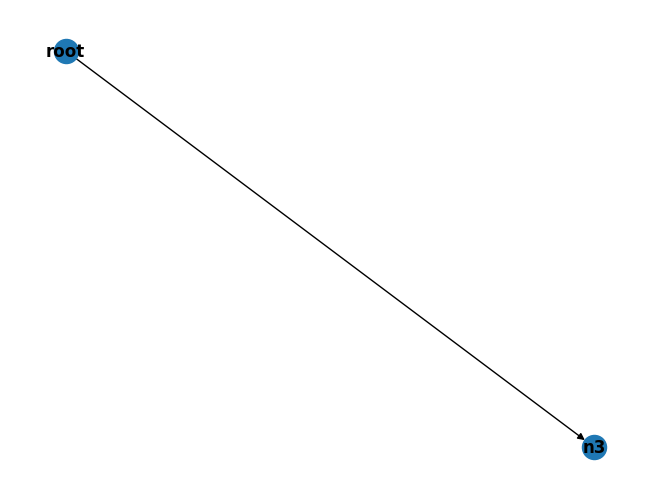

In [146]:
nx.draw(t._forward_view(), with_labels=True, font_weight='bold')


In [ ]:
n2.add(n3)

In [ ]:
g = nx.DiGraph()

In [ ]:
g.add_node("a")
g.add_node("b")
g.add_node("c")

g.add_edge("a", "b", forward=True)
g.add_edge("b", "a", forward=False)
g.add_edge("a", "c", forward=True)
g.add_edge("c", "a", forward=False)

In [ ]:
"f" in g

False

In [ ]:
node = "c"
next((x for x in g.neighbors(node) if not g[node][x]['forward']))

'a'

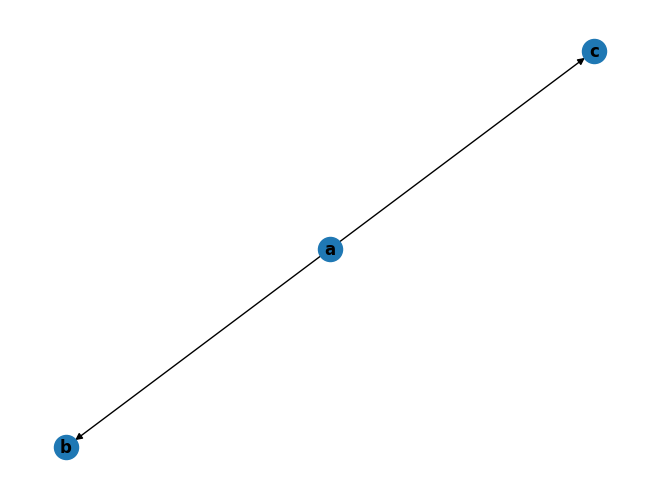

In [ ]:
g2=nx.subgraph_view(g, filter_edge=lambda u, v: g[u][v]['forward'])
nx.draw(g2, with_labels=True, font_weight='bold')

In [ ]:
path = nx.shortest_path(g, "b", "c")
print(path)

# print edges
for i in range(len(path) - 1):
    print(g[path[i]][path[i+1]], path[i], path[i+1])

['b', 'a', 'c']
{'forward': False} b a
{'forward': True} a c


In [ ]:
# print all edges from a
for i in g["a"]:
    print(g["a"][i], "a", i)

{'forward': True} a b
{'forward': True} a c


In [ ]:
from deepdrr.frontend.renderer import SynchronousRenderer


volume = Volume.from_nrrd("hu_values.nrrd")
mesh1 = Mesh.from_stl("mesh1.stl", tag="mesh1")
mesh2 = Mesh.from_stl("mesh2.stl", tag="mesh2")

carm = MobileCArm()

graph = TransformTree()
graph.add(carm)
graph.add(volume)
graph.add(mesh1)
graph.add(mesh2)

scene = GraphScene(graph)

drr_settings = DRRRenderSettings(
    width=512,
    height=512,
    neglog=True,
)
drr_prof = DRRRenderProfile(
    settings=drr_settings,
    renderer=SynchronousRenderer(),
    scene=scene
)

rast_settings = RasterizeRenderSettings(
    width=512,
    height=512,
    max_mesh_hits=32,
)
rasterize_prof = RasterizeRenderProfile(
    settings=rast_settings,
    renderer=SynchronousRenderer(),
    scene=scene
)

mesh1.world_from_anatomical = geo.FrameTransform.from_translation([-30, 50, 200])

for frame_idx in range(10):
    mesh2.world_from_anatomical = geo.FrameTransform.from_translation([0, 0, 10*frame_idx])

    carm.move_by(
        delta_isocenter=[0, 0, 10],
        delta_alpha=5*frame_idx,
        delta_beta=0,
        delta_gamma=0,
        degrees=False,
    )

    drr = drr_prof.render_drr()

    segs = rasterize_prof.render_seg()
    hits = rasterize_prof.render_hits()


    

In [ ]:
a = Primitive(primitive_id="a", data=StlMesh(url="file:///home/pelvisvr/datasets/DeepDRR_DATA/CT-chest.nrrd", material_name="material_name", density=1.0, priority=1, addtive=True, subtractive=True))
b = Primitive(primitive_id="b", data=H5Volume(url="file:///home/pelvisvr/datasets/DeepDRR_DATA/CT-chest.nrrd", priority=1))

cam = Camera(transform=Matrix4x4(data=np.eye(4).flatten()), intrinsic=CameraIntrinsic(fx=1.0, fy=1.0, cx=0.0, cy=0.0, near=1.0, far=100.0))
inst = Instance(primitive_id="a", transform=Matrix4x4(data=np.eye(4).flatten()), morph_weights=[1.0, 2.0, 3.0])
frame = Frame(camera=cam, instances=[inst])

In [ ]:
c = Scene(primitives=[a,b], frames=[frame])

In [ ]:
# save to asdf.json

with open("asdf.json", "w") as f:
    f.write(c.model_dump_json(indent=2))

In [ ]:
# load
with open("asdf.json", "r") as f:
    d = Scene.model_validate_json(f.read())

d

Scene(primitives=[Primitive(primitive_id='a', data=StlMesh(prim_data_type='StlMesh', url=Url('file:///home/pelvisvr/datasets/DeepDRR_DATA/CT-chest.nrrd'), material_name='material_name', density=1.0, priority=1, addtive=True, subtractive=True)), Primitive(primitive_id='b', data=H5Volume(prim_data_type='H5Volume', url=Url('file:///home/pelvisvr/datasets/DeepDRR_DATA/CT-chest.nrrd'), priority=1))], frames=[Frame(camera=Camera(transform=Matrix4x4(data=[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]), intrinsic=CameraIntrinsic(fx=1.0, fy=1.0, cx=0.0, cy=0.0, near=1.0, far=100.0)), instances=[Instance(primitive_id='a', transform=Matrix4x4(data=[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]), morph_weights=[1.0, 2.0, 3.0])])])

In [ ]:
a.data.url.path

'/home/pelvisvr/datasets/DeepDRR_DATA/CT-chest.nrrd'

In [ ]:
import urllib.request

o = urllib.request.urlopen("file:///home/pelvisvr/datasets/DeepDRR_DATA/CT-chest.nrrd")

asdf = o.read()

print(len(asdf) / 1e6)

42.189103


In [ ]:
type(asdf)

bytes